In [1]:
import numpy as np
import pandas as pd
import string
import xgboost as xgb
import io
import nltk
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('stopwords')
stopwords = stopwords.words('english')
stemmer = SnowballStemmer('english')

from textblob import TextBlob
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
pd.set_option('mode.chained_assignment', None)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mausa\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mausa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mausa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\mausa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
tweets = pd.read_csv("train.csv", usecols=['id','text', 'target'])
test = pd.read_csv("test.csv", usecols=['id','text'])

In [3]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7434 non-null   int64 
 1   text    7434 non-null   object
 2   target  7434 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 232.3+ KB


# Data loading.


In [4]:
train_complete = pd.read_csv('train_complete.csv')
test_complete = pd.read_csv('test_complete.csv')

In [5]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [6]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding='utf8') as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

def create_embedding_matrix_840(route, word_index, embedding_dim):
    embeddings_index = {}
    f = open(route, encoding='utf8')
    for line in f:
        values = line.split()
        word = ''.join(values[:-embedding_dim])
        coefs = np.asarray(values[-embedding_dim:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: # Si la palabra no esta queda llena de 0s
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Models.

### GridSearch.

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Concatenate, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Lambda, Activation, GaussianNoise, GaussianDropout
from keras import layers, Input, Model
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.constraints import max_norm, unit_norm, min_max_norm
from tensorflow import keras

In [237]:
def create_conv1d(num_filters, kernel_size,vocab_size,embedding_dim,maxlen,batch_size,dense1_size,dense2_size):
    embedding = Embedding(vocab_size, embedding_dim, input_length=maxlen, weights=[embedding_matrix], trainable=True)
    x_train_input = Input(shape = (maxlen,), name = 'x_train_input')
    x_train_features_input = Input(shape = (15, ), name = 'x_features_train')
    emb = embedding(x_train_input)
    
    conv_out = Conv1D(num_filters, kernel_size, activation='relu')(emb)
    max_pool = GlobalMaxPooling1D()(conv_out)
    
    conc = Concatenate()([max_pool, x_train_features_input])
   
    dense1 = Dense(dense1_size, activation='relu')(conc)
    dense2 = Dense(dense2_size, activation='relu')(dense1)
    
    model = Model(inputs = [x_train_input , x_train_features_input], outputs = dense2)
    return model

def create_port_to_model(num_filters, kernel_size,vocab_size,embedding_dim,maxlen,batch_size,dense1_size,dense2_size):
    combi_input = Input(shape = (155,), name = 'port')
    input_train = Lambda(lambda x: x[:,:-15])(combi_input)
    input_features = Lambda(lambda x: x[:,140:])(combi_input)

    base_network = create_conv1d(num_filters, kernel_size,vocab_size,embedding_dim,maxlen,batch_size,dense1_size,dense2_size)
    processed = base_network([input_train,input_features])

    dense3 = Dense(1, activation='sigmoid')(processed)
    model = Model(combi_input,dense3)
    optimizer = Adam() #default
    model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model

In [238]:
callback = EarlyStopping(monitor = 'val_loss', patience = 1, verbose=1)

x_train = tweets_metrics['text'].values
y_train = tweets_metrics['target'].values
features = StandardScaler()
x_train_features = features.fit_transform(basic_features)

epochs = 15
embedding_dim = 100
maxlen = 140
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
vocab_size = len(tokenizer.word_index) + 1
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)

embedding_matrix = create_embedding_matrix('Embeddings/glove.twitter.27B.100d.txt',tokenizer.word_index, embedding_dim)

In [239]:
param_grid = dict(num_filters=[128],
                      kernel_size=[7],
                      vocab_size=[vocab_size],
                      embedding_dim=[embedding_dim],
                      maxlen=[maxlen],
                      batch_size = [88],
                      dense1_size = [10],
                      dense2_size = [20,10])

model = KerasClassifier(build_fn=create_port_to_model,
                            epochs=epochs, validation_split=0.1,
                            verbose=1)

grid = GridSearchCV(estimator=model, param_grid=param_grid,
                              cv=4, verbose=2, n_jobs=1)

grid_result = grid.fit(np.concatenate((x_train,x_train_features), axis = 1), y_train, callbacks=[callback])

s = ('Best Accuracy : {:.4f}\n{}\n\n\n')
output_string = s.format(
            grid_result.best_score_,
            grid_result.best_params_)
print(output_string)

Fitting 4 folds for each of 2 candidates, totalling 8 fits
[CV] batch_size=88, dense1_size=10, dense2_size=20, embedding_dim=100, kernel_size=7, maxlen=140, num_filters=128, vocab_size=22811 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
Train on 5017 samples, validate on 558 samples
Epoch 1/15
5017/5017 [==============================] - 9s 2ms/step - loss: 0.5171 - accuracy: 0.7473 - val_loss: 0.5379 - val_accuracy: 0.7509
Epoch 2/15
5017/5017 [==============================] - 10s 2ms/step - loss: 0.3783 - accuracy: 0.8385 - val_loss: 0.4833 - val_accuracy: 0.7652
Epoch 3/15
5017/5017 [==============================] - 9s 2ms/step - loss: 0.2915 - accuracy: 0.8882 - val_loss: 0.4813 - val_accuracy: 0.7796
Epoch 4/15
5017/5017 [==============================] - 8s 2ms/step - loss: 0.2236 - accuracy: 0.9197 - val_loss: 0.4517 - val_accuracy: 0.8047
Epoch 5/15
5017/5017 [==============================] - 9s 2ms/step - loss: 0.1452 - accuracy: 0.9569 -

In [242]:
pd.DataFrame(grid_result.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_dense1_size,param_dense2_size,param_embedding_dim,param_kernel_size,param_maxlen,param_num_filters,param_vocab_size,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,28.782677,10.218281,0.639944,0.032818,88,10,20,100,7,140,128,22811,"{'batch_size': 88, 'dense1_size': 10, 'dense2_...",0.789672,0.766541,0.771798,0.789020,0.779258,0.010261,2
1,36.360590,6.298348,0.661582,0.020972,88,10,10,100,7,140,128,22811,"{'batch_size': 88, 'dense1_size': 10, 'dense2_...",0.791286,0.786444,0.778256,0.785791,0.785444,0.004661,1


### Individual model.

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Concatenate, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Lambda, Activation, GaussianNoise, GaussianDropout, Bidirectional, CuDNNLSTM, LSTM
from keras import layers, Input, Model, initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score
from tensorflow.keras.constraints import max_norm, unit_norm, min_max_norm
from tensorflow import keras
from keras.engine.topology import Layer
import tensorflow as tf
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [9]:
scaler = StandardScaler()
x_train_features = scaler.fit_transform(train_complete.loc[:,'id':])

x_train = train_complete['processed_text'].values
y_train = train_complete['target'].values

tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)

vocab_size = len(tokenizer.word_index) + 1
maxlen = 50
x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)

In [10]:
result = pd.read_csv('perfect_submission.csv')
test_kagle = test_complete[['id','text']]

x_test_kagle = test_complete['processed_text'].values
x_test_kagle = tokenizer.texts_to_sequences(x_test_kagle)
x_test_kagle = pad_sequences(x_test_kagle, padding='post', maxlen=maxlen)
x_test_features = scaler.transform(test_complete.loc[:,'id':])

In [11]:
embedding_dim_1 = 100
embedding_matrix_1 = create_embedding_matrix('Embeddings/glove.twitter.27B.100d.txt',tokenizer.word_index, embedding_dim_1)

#embedding_dim_2 = 300
#embedding_matrix_2 = create_embedding_matrix_840('Embeddings/glove.840B.300d.txt',tokenizer.word_index, embedding_dim_2)

#embedding_dim_3 = 200
#embedding_matrix_3 = create_embedding_matrix('Embeddings/glove.6B.200d.txt',tokenizer.word_index, embedding_dim_3)

In [15]:
def create_conv1d(dense_1=146,conv1=256,conv2=128): #original
        
    embedding = Embedding(vocab_size, embedding_dim_1, input_length=maxlen, weights=[embedding_matrix_1], trainable=True)

    x_train_input = Input(shape = (maxlen,), name = 'x_train_input')
    x_train_features_input = Input(shape = (218, ), name = 'x_features_train')

    emb = embedding(x_train_input)
    #conv_out2_1 = Conv1D(128, 2, activation='relu', kernel_constraint=max_norm(3), bias_constraint=max_norm(3))(emb2)
    
    conv_out1 = Conv1D(conv1, 2, activation='relu')(emb)
    activation1 = Activation('relu')(conv_out1)
    max_pool1 = GlobalMaxPooling1D()(activation1)
    conv_out2 = Conv1D(conv2, 2, activation='relu')(emb)
    activation2 = Activation('relu')(conv_out2)
    max_pool2 = GlobalMaxPooling1D()(activation2)

    conc = Concatenate()([max_pool2, max_pool1, x_train_features_input])
    
    #dense1 = Dense(28, activation='relu')(conc)
    #noise2 = GaussianNoise(0.15)(dense1)
    #drop = Dropout(0.3)(dense1)
    
    dense2 = Dense(dense_1, activation='relu')(conc) #, kernel_regularizer=keras.regularizers.l2(0.01)
    dense3 = Dense(1, activation='sigmoid')(dense2)
    
    model = Model(inputs = [x_train_input , x_train_features_input], outputs = dense3)
    optimizer = Adam() #default
    model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    return model

In [18]:
model = create_conv1d(5,256,160)
history = model.fit([x_train,x_train_features], y_train,
                    epochs=2,
                    verbose=1,
                    batch_size=75)

Epoch 1/2
7434/7434 [==============================] - 7s 950us/step - loss: 0.5351 - accuracy: 0.7147
Epoch 2/2
7434/7434 [==============================] - 7s 972us/step - loss: 0.3794 - accuracy: 0.8391


In [19]:
submit_df = pd.DataFrame()
submit_df['id'] = test_kagle['id']
submit_df['prob'] = model.predict([x_test_kagle,x_test_features])
submit_df['target'] = submit_df['prob'].apply(lambda x: 0 if x < .5 else 1)

accuracy = accuracy_score(submit_df['target'], result['target'])
print(accuracy)

0.8145878026356114


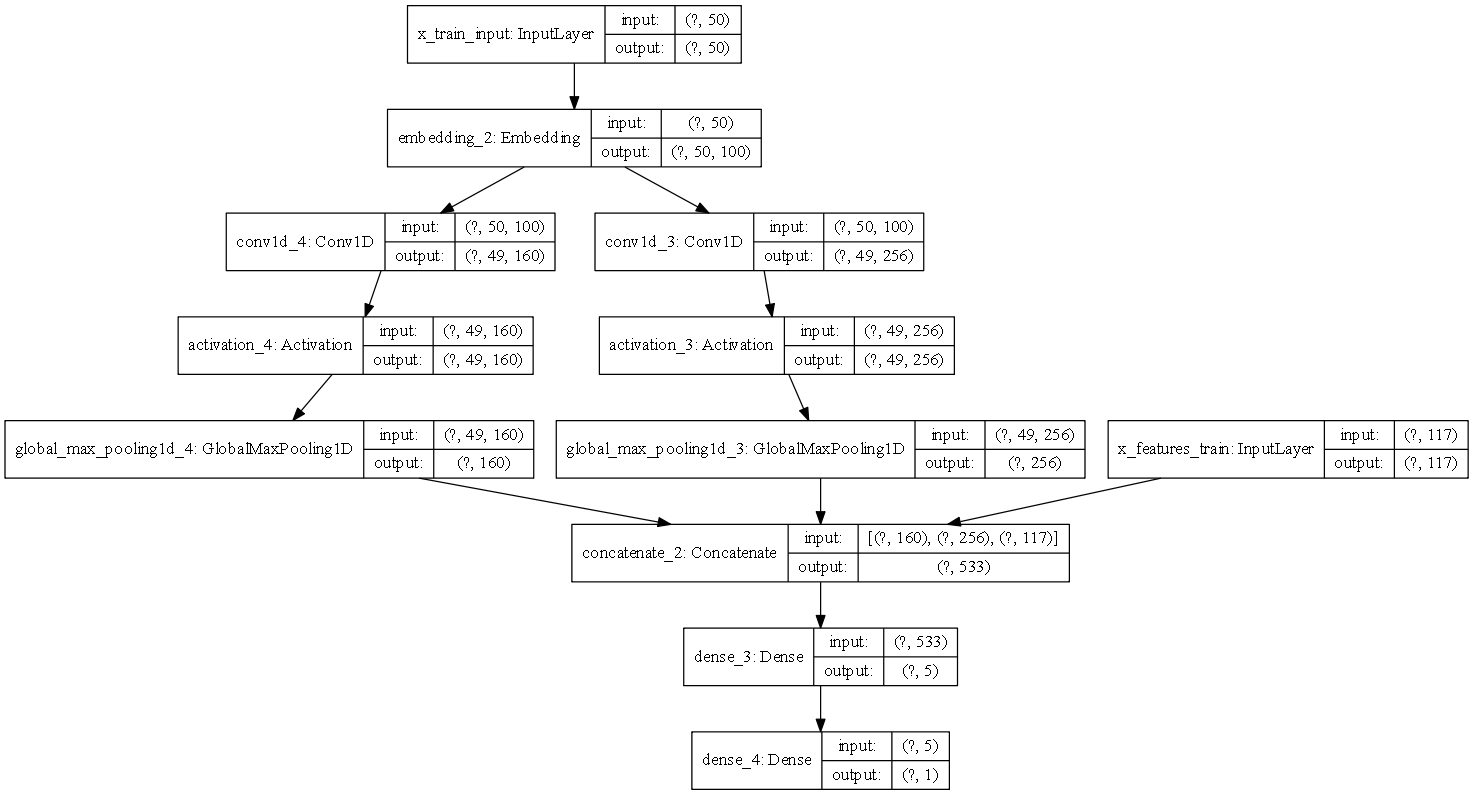

In [20]:
keras.utils.plot_model(model, show_shapes=True, dpi=90)

In [ ]:
0.82531

In [212]:
del submit_df['prob']
submit_df.to_csv("submit_prueba_47.csv", index=False)

In [20]:
for i in range(125,152):
    model = create_conv1d(i)
    history = model.fit([x_train,x_train_features], y_train,
                    epochs=2,
                    verbose=0,
                    batch_size=69)
    submit_df = pd.DataFrame()
    submit_df['id'] = test_kagle['id']
    submit_df['prob'] = model.predict([x_test_kagle,x_test_features])
    submit_df['target'] = submit_df['prob'].apply(lambda x: 0 if x < .5 else 1)

    accuracy = accuracy_score(submit_df['target'], result['target'])
    if accuracy > 0.82:
        print(f'Capa Densa Cantidad: {i} - Score: {accuracy}')
    if accuracy > 0.8257:
        break

Capa Densa Cantidad: 127 - Score: 0.8201041985902544
Capa Densa Cantidad: 148 - Score: 0.8210235979160282
Capa Densa Cantidad: 150 - Score: 0.8201041985902544


### Verificación de misslabeled tweets individuales.

In [180]:
import csv
pa_checkear = test_w_features[['id','text']]
pa_checkear['target'] = result['target']
with open('perfect_submission.csv') as perfecto, open('submit_prueba_43.csv') as submit:
    perfect_csv = csv.reader(perfecto)
    submit_csv = csv.reader(submit)
    perf = {}
    subm = {}
    misseados = []
    for id,target in perfect_csv:
        perf[id] = perf.get(id,target)
    for id,target in submit_csv:
        subm[id] = subm.get(id,target)
    for id in subm:
        if subm[id] != perf[id]:
            misseados.append(id)
    for i in range(len(misseados)):
        misseados[i] = int(misseados[i])

In [184]:
len(misseados)

569

In [181]:
pa_checkear['wrong_label'] = pa_checkear['id'].apply(lambda x: x in misseados)
pa_checkear[pa_checkear['wrong_label'] == True].to_csv('mal_labeleados.csv', index = False)

In [193]:
pa_checkear[pa_checkear['wrong_label'] == True]['text'].str.contains('http').value_counts()

False    287
True     282
Name: text, dtype: int64